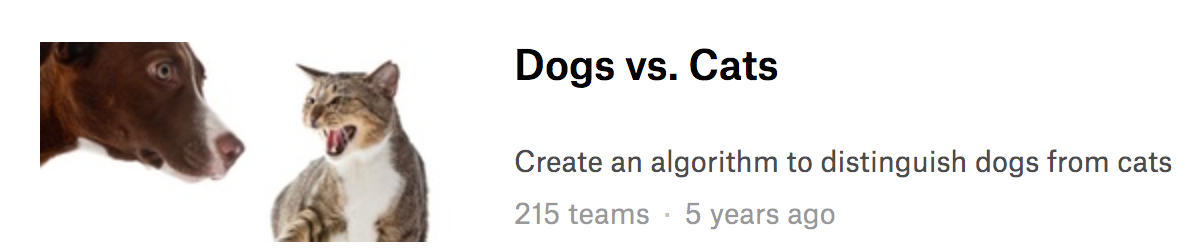
kaggle上猫狗图像分类的公开数据集，数据集由训练数据和测试数据组成，训练数据包含猫和狗各12500张图片，测试数据包含12500张猫和狗的图片，本次案例中只使用了训练集数据。

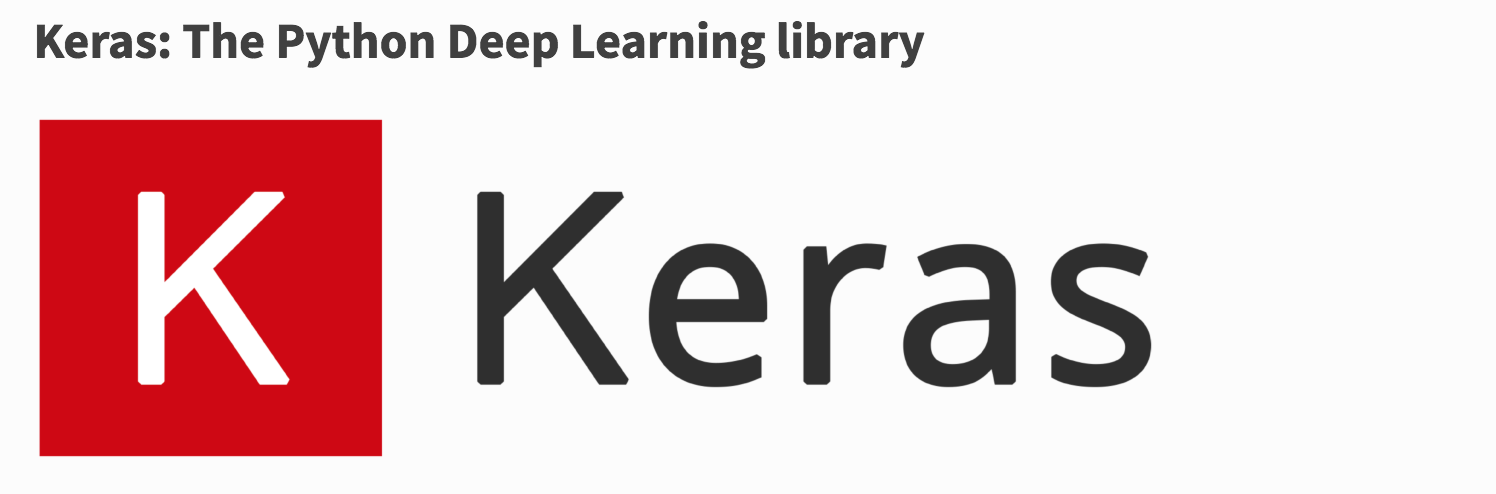
Keras是一个高层神经网络API，Keras由纯Python编写而成并将Tensorflow进行了高级封装。Keras 为支持快速实验而生，能够把你的idea迅速转换为结果，

In [19]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '7'

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
sess = tf.Session(config=config)

In [20]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import random
import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
TRAIN_DIR = './train/'

ROWS = 150
COLS = 150
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

train_images = train_dogs[:1000] + train_cats[:1000]

In [22]:
from tqdm import tqdm

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    b,g,r = cv2.split(img)
    img2 = cv2.merge([r,g,b])
    return cv2.resize(img2, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
    for i, image_file in enumerate(tqdm(images)):
        image = read_image(image_file)
        data[i] = image

    return data

In [23]:
train = prep_data(train_images)
print("Train shape: {}".format(train.shape))

100%|██████████| 2000/2000 [00:31<00:00, 63.20it/s]

Train shape: (2000, 150, 150, 3)


In [24]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

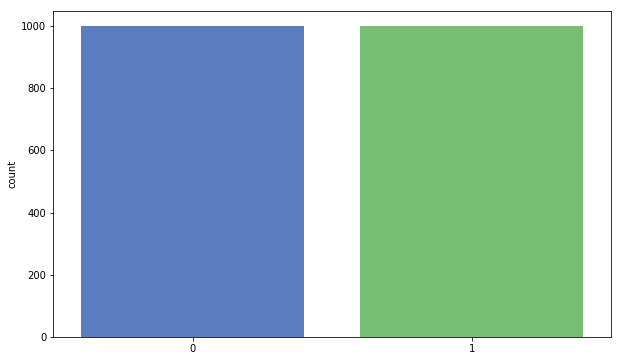

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(labels)

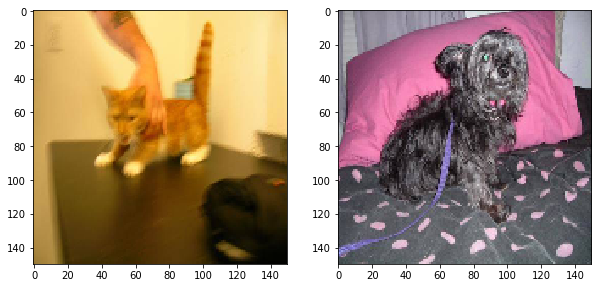

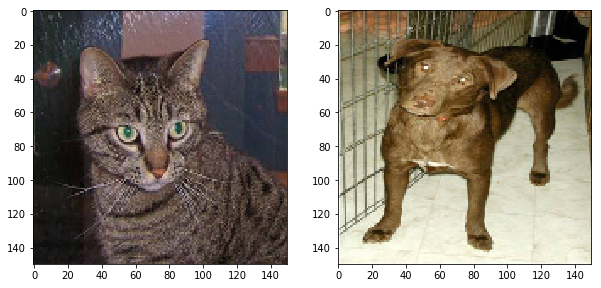

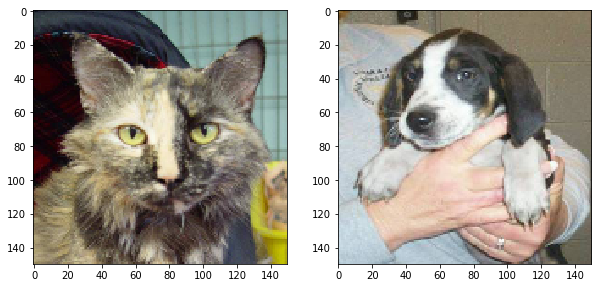

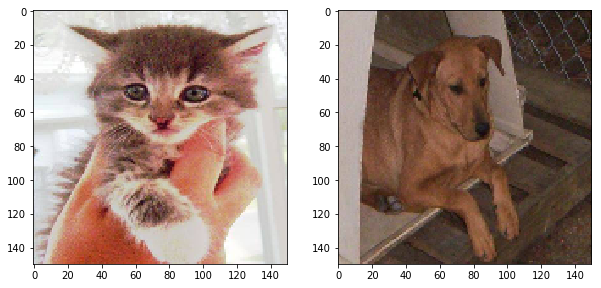

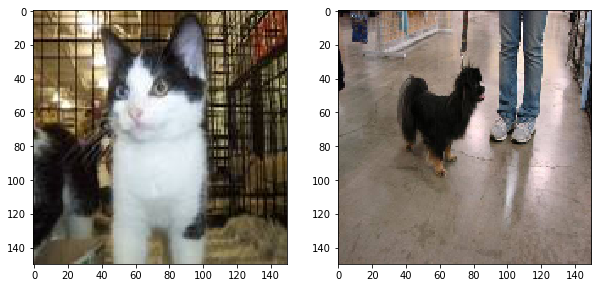

In [26]:
def show_cats_and_dogs(idx):
    cat = read_image(train_cats[idx])
    dog = read_image(train_dogs[idx])
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(cat)
    plt.subplot(122)
    plt.imshow(dog)
    plt.show()
    
for idx in range(0, 5):
    show_cats_and_dogs(idx)

In [9]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

train = train / 255.
train_input, val_input, train_label, val_label = train_test_split(
    train, labels, test_size=0.2, shuffle=True
)

Using TensorFlow backend.


In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
def catdog_model():
    
    model = Sequential()

    model.add(Conv2D(32, 3, padding='same', input_shape=train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    print("Compiling model...")

    optimizer = Adam(lr=1e-3)
    objective = 'binary_crossentropy'
    
    model.compile(loss=objective, optimizer='rmsprop', metrics=['accuracy'])
    return model

In [11]:
from keras.utils import plot_model
plot_model(catdog_model())

Compiling model...


In [12]:
catdog_model().summary()

Compiling model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 20736)             0 

In [13]:
epochs = 10
batch_size = 256

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')        

model = catdog_model()

print("running model...")
history = model.fit(train_input, train_label, batch_size=batch_size, epochs=epochs,
          validation_data=(val_input, val_label), verbose=2, 
          shuffle=True)

Compiling model...
running model...
Train on 12 samples, validate on 4 samples
Epoch 1/10
 - 9s - loss: 0.6928 - acc: 0.4167 - val_loss: 4.6353e-06 - val_acc: 1.0000
Epoch 2/10
 - 7s - loss: 4.1393e-05 - acc: 1.0000 - val_loss: 2.6051e-07 - val_acc: 1.0000
Epoch 3/10
 - 6s - loss: 2.9701e-05 - acc: 1.0000 - val_loss: 1.0778e-07 - val_acc: 1.0000
Epoch 4/10
 - 6s - loss: 3.3583e-06 - acc: 1.0000 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 5/10
 - 6s - loss: 1.2842e-06 - acc: 1.0000 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 6/10
 - 6s - loss: 4.8335e-05 - acc: 1.0000 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 7/10
 - 6s - loss: 5.0439e-07 - acc: 1.0000 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 8/10
 - 6s - loss: 3.2064e-07 - acc: 1.0000 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 9/10
 - 6s - loss: 1.2617e-06 - acc: 1.0000 - val_loss: 1.0000e-07 - val_acc: 1.0000
Epoch 10/10
 - 6s - loss: 1.1812e-07 - acc: 1.0000 - val_loss: 1.0000e-07 - val_acc: 1.0000


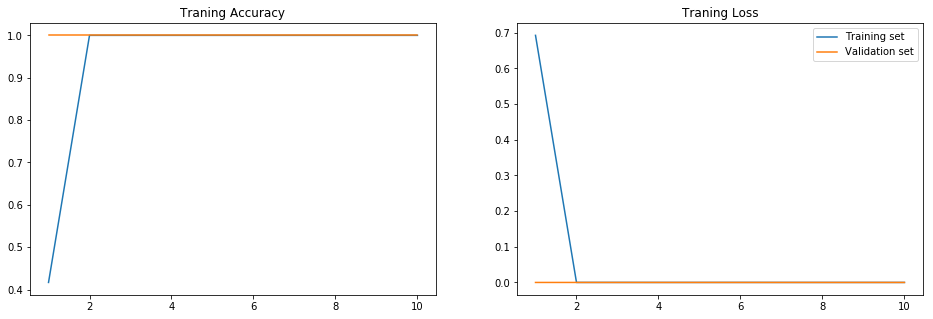

In [14]:
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(range(1, len(history.history['acc']) + 1), history.history['acc'], label='Training set')
plt.plot(range(1, len(history.history['val_acc']) + 1), history.history['val_acc'], label='Validation set')
plt.title('Traning Accuracy')

plt.subplot(122)
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Training set')
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation set')
plt.title('Traning Loss')

plt.legend()

In [15]:
from keras.models import load_model
model = load_model('train_50.h5')
history = np.load('train_history_50.npy').item()

Text(0.5,1,'Traning Loss')

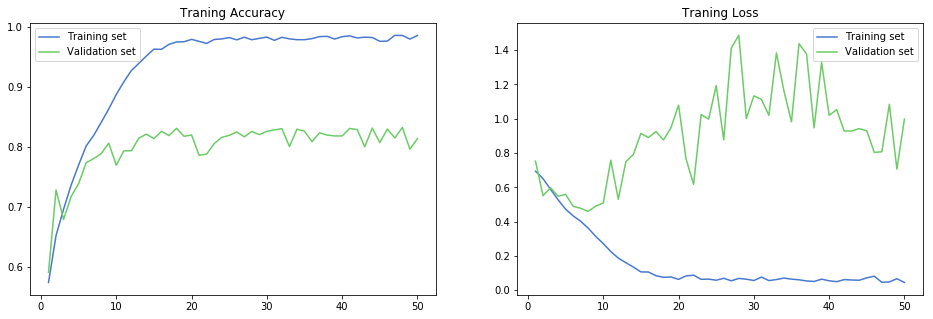

In [16]:
plt.style.use('seaborn-muted')

plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(range(1, len(history['acc']) + 1), history['acc'], label='Training set')
plt.plot(range(1, len(history['val_acc']) + 1), history['val_acc'], label='Validation set')
plt.legend()
plt.title('Traning Accuracy')

plt.subplot(122)
plt.plot(range(1, len(history['loss']) + 1), history['loss'], label='Training set')
plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label='Validation set')
plt.legend()
plt.title('Traning Loss')

I am 99.96% sure this is a Cat


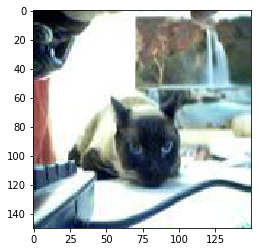

I am 99.97% sure this is a Cat


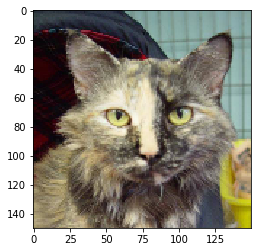

I am 100.00% sure this is a Cat


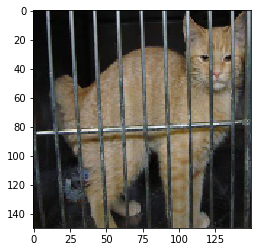

I am 100.00% sure this is a Cat


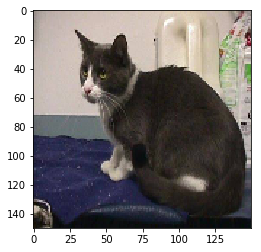

IndexError: index 4 is out of bounds for axis 0 with size 4

In [17]:
preds = model.predict(val_input)

for i in range(0,10):
    if preds[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(preds[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1 - preds[i][0]))
        
    plt.imshow(val_input[i])
    plt.show()